In [1]:
import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np
from matplotlib.pyplot import imshow #to show test case

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim import lr_scheduler
from torch.autograd import Variable
from collections import OrderedDict

import os
import copy
import time

In [2]:
BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 0.001
SGD_MOMENTUM = 0.5
SEED = 1
LOG_INTERVAL = 10
MODEL_PATH = 'models/resnet18_beatbox_classifier.pth'

In [3]:
# Enable Cuda
torch.cuda.manual_seed(SEED)

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(512),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(512),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(512),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'melspectrogram/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['DNB', 'Dubstep', 'Grime', 'House', 'Reggae', 'Trap']


In [5]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs.size())

torch.Size([16, 3, 512, 512])


In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
model_ft = models.resnet18(pretrained=True)
# for param in model_ft.parameters():
#     param.requires_grad = False

# #Classifier architecture to put on top of resnet18
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,150)),
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.4)),
    ('fc2', nn.Linear(150,6)),
    ('output', nn.Softmax(dim=1))
]))

model_ft.fc = fc

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=EPOCHS)

Epoch 1/10
----------
train Loss: 1.7592 Acc: 0.2917
val Loss: 1.7657 Acc: 0.3889

Epoch 2/10
----------
train Loss: 1.5783 Acc: 0.8403
val Loss: 1.5358 Acc: 0.9722

Epoch 3/10
----------
train Loss: 1.3951 Acc: 0.9722
val Loss: 1.2759 Acc: 0.9931

Epoch 4/10
----------
train Loss: 1.2359 Acc: 0.9931
val Loss: 1.1184 Acc: 1.0000

Epoch 5/10
----------
train Loss: 1.1467 Acc: 1.0000
val Loss: 1.0711 Acc: 1.0000

Epoch 6/10
----------
train Loss: 1.0915 Acc: 1.0000
val Loss: 1.0542 Acc: 1.0000

Epoch 7/10
----------
train Loss: 1.0763 Acc: 1.0000
val Loss: 1.0496 Acc: 1.0000

Epoch 8/10
----------
train Loss: 1.0693 Acc: 1.0000
val Loss: 1.0496 Acc: 1.0000

Epoch 9/10
----------
train Loss: 1.0763 Acc: 1.0000
val Loss: 1.0489 Acc: 1.0000

Epoch 10/10
----------
train Loss: 1.0634 Acc: 1.0000
val Loss: 1.0490 Acc: 1.0000

Training complete in 0m 43s
Best val Acc: 1.000000


In [12]:
!mkdir models/
torch.save(model_ft, MODEL_PATH)

In [13]:
model_ft = torch.load(MODEL_PATH)

model_ft = model_ft.to(device)
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

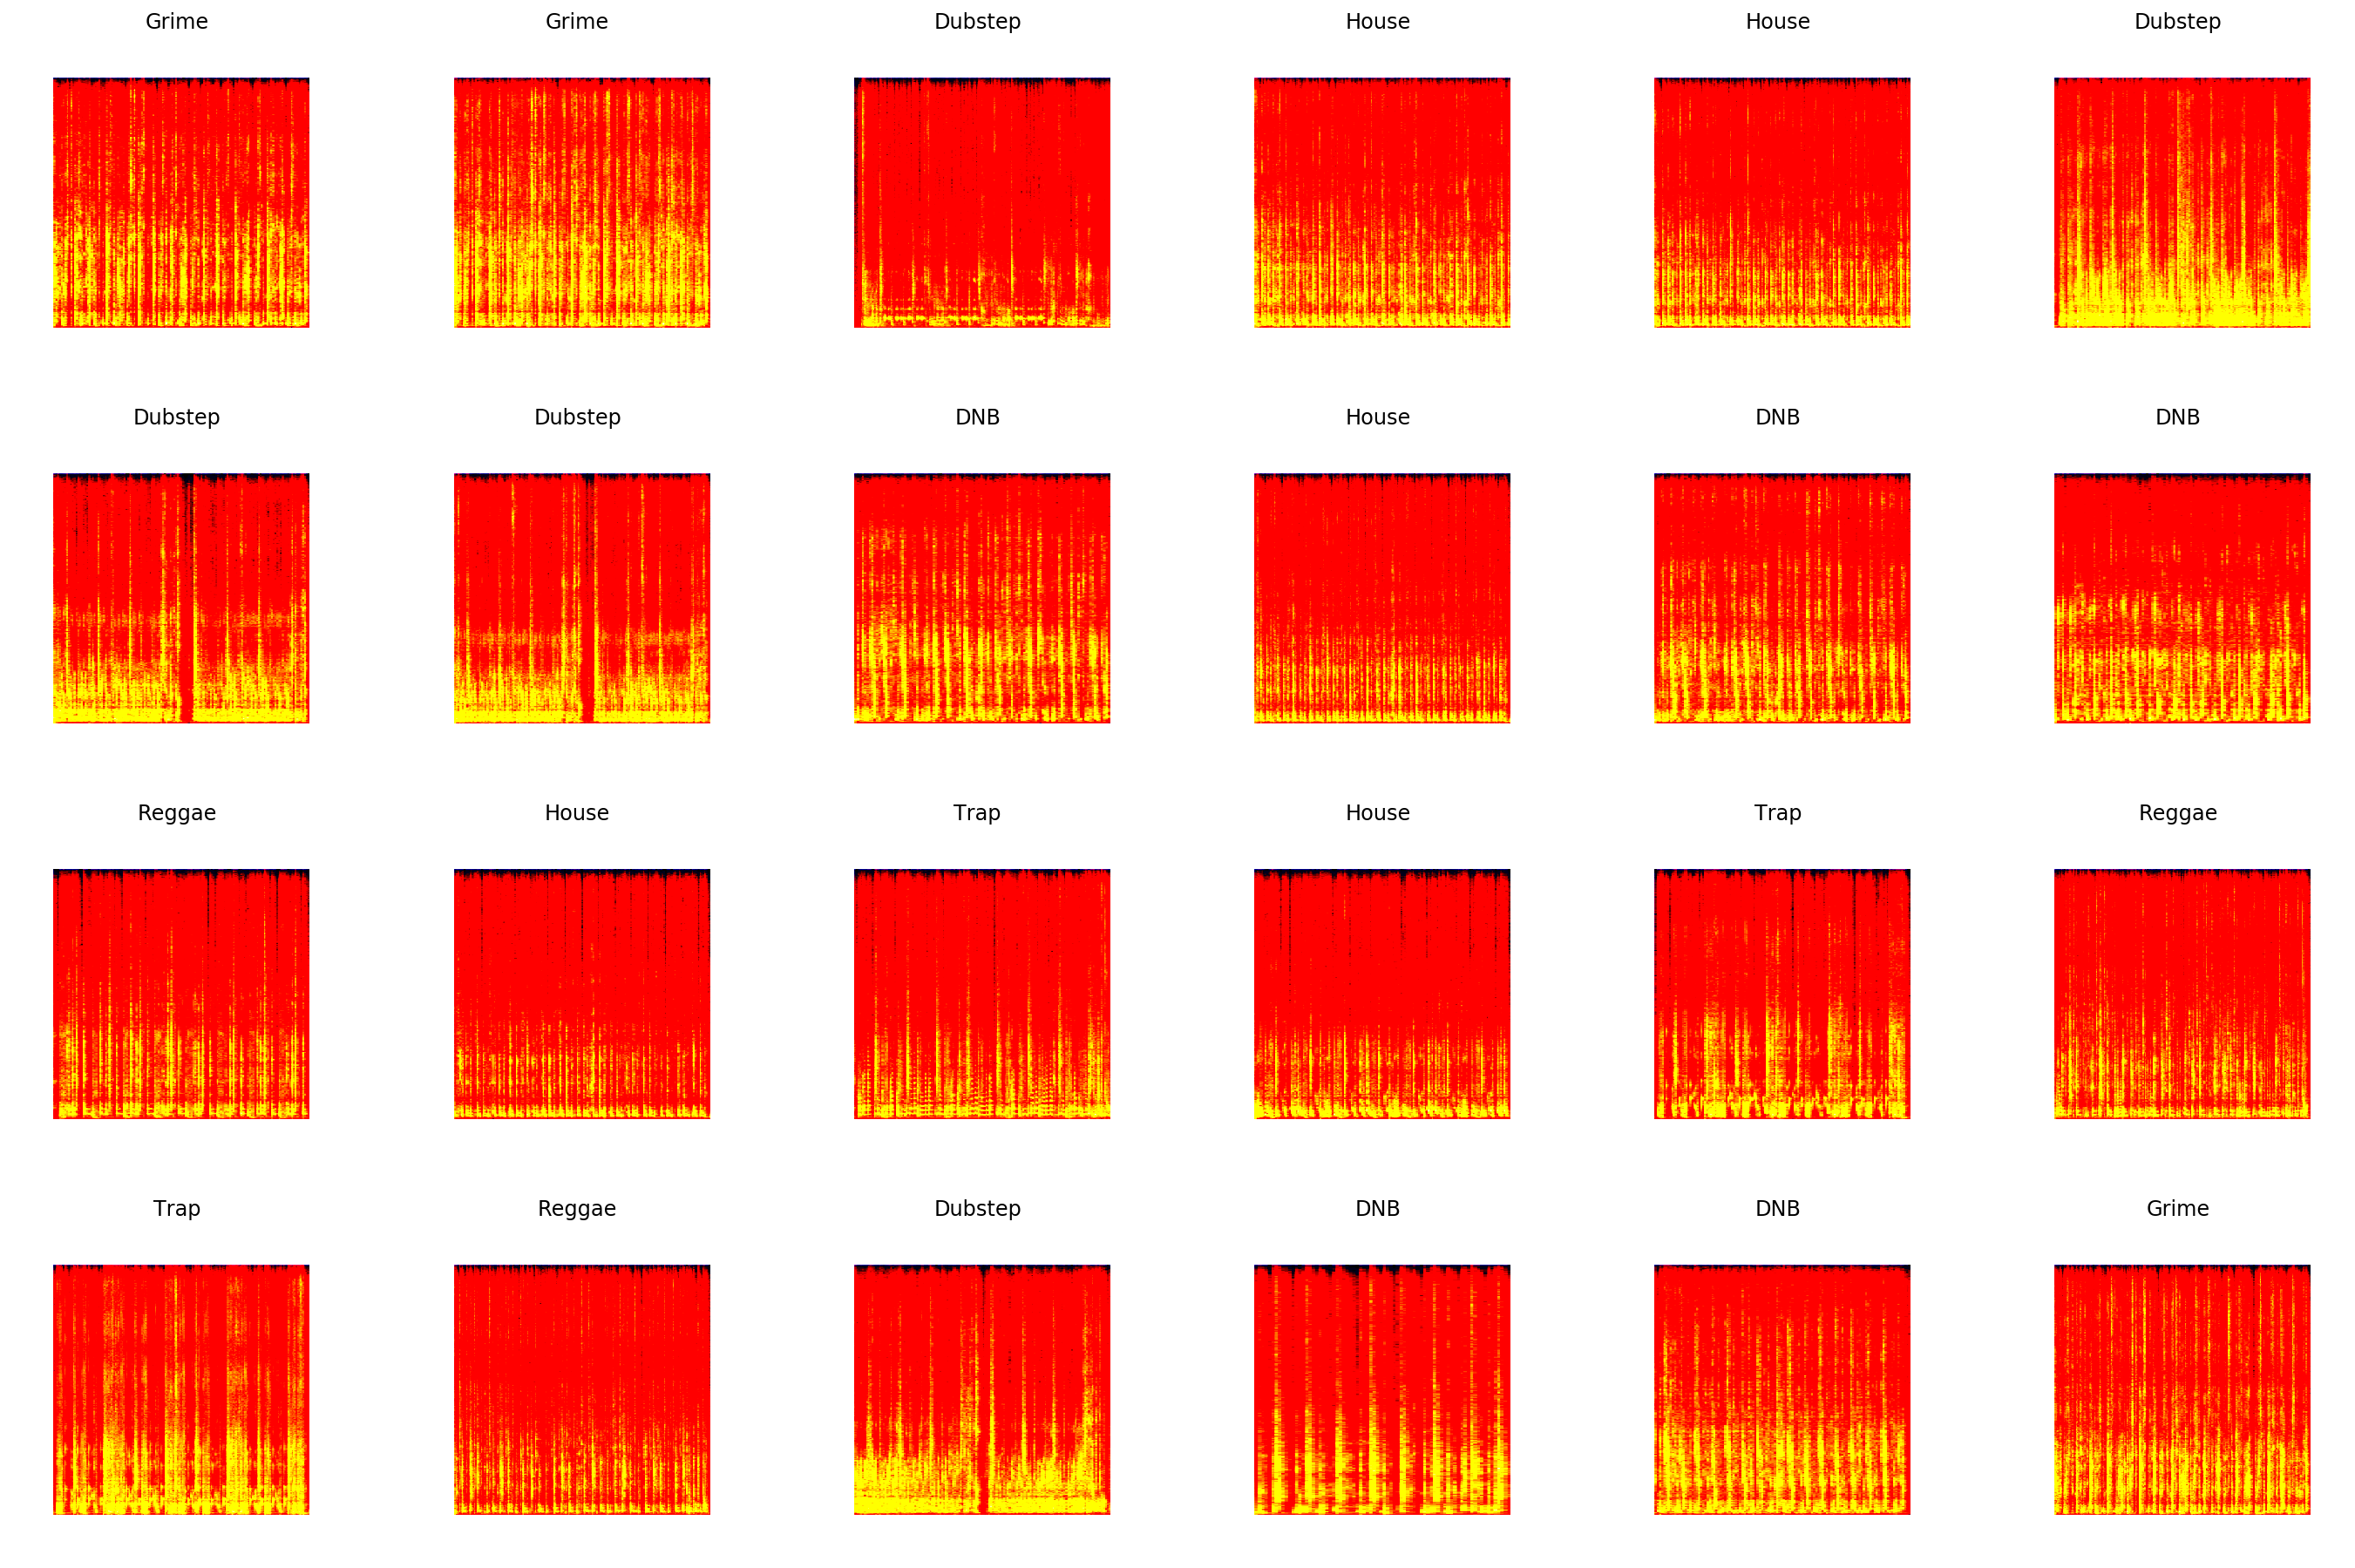

In [16]:
#Transform the test dataset
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

test_transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor()
])

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=48,
                                             shuffle=True, num_workers=1)
              for x in ['val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['val']}
fn_list = []
pred_list = []
# for x, fn in dataloaders:
#     with torch.no_grad():
#         x = x.to(device)
#         output = model(x)
#         pred = torch.argmax(output, dim=1)
#         fn_list += [n[:-4] for n in fn]
#         pred_list += [p.item() for p in pred]

inputs, classes = next(iter(dataloaders['val']))
inputs = inputs.to(device)

output = model_ft(inputs[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]

ad = {0:'DNB', 1:'Dubstep', 2:'Grime', 3:'House', 4:'Reggae', 5:'Trap'}
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
for num, sample in enumerate(inputs[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))